## Named Entity Recognition: Examining the Stanford NER Tagger

###Overview

Recently I landed a job at URX through a data science job placement program for people with quantitative PhDs called [Insight Data Science](http://insightdatascience.com/). As part of a [new initative within the program](http://insightdatascience.com/blog/data-science-at-startups.html), I was offered the opportunity to work with URX on a unique data science challenge that held real business value. The goal was to develop an Named Entity Recognition (NER) classifier that could be compared favorably to one of the state-of-the-art (but commercially licensed) NER classifiers developed by the CoreNLP lab at Stanford University over a number of years. 

###Project

Named entity recognition is the process of identifying named entities in text, and is a required step in the process of building out the [URX Knowledge Graph](http://blog.urx.com/urx-blog/2015/5/29/deep-links-knowledge-graphs). For the sentence **"Dave Matthews leads the Dave Matthews Band, and is an artist born in Johannesburg"** we need an automated way of assigning the first and second tokens to "Person", the fifth and sixth tokens to "Organization", and the last token to "Location". Named Entity Recognition is a notoriously challenging task in Natural Language Processing given that there are an infinite number of named entities, and there may be many ways to represent a given named entity (Dave Matthews, Dave matthews, David Matthews, etc). A good NER system must label "Dave Matthews Band" as an organization, and "Dave Matthews" as a person, even though they share two out of three tokens. The most intelligent NER taggers find ways to use features derived from surrounding tokens to make the best possible prediction about the class of a given token.

The performance of NER classifiers is evaluated similarly to traditional machine learning algorithms, using metrics such as the F1-score. However, we are concerned not only with accuracy, but also with speed. When crawling new web pages for our corpus, it is essential that entities are extracted in real-time (for more about our web crawling, please see our [Science of Crawl series](http://blog.urx.com/urx-blog/2014/9/4/the-science-of-crawl-part-1-deduplication-of-web-content)).

For my project, I compared the Stanford tagger with a relatively simple tagger I build during my time at Insight. Often considered the benchmark tagger in empirical research due to its high accuracy, the Stanford tagger has evolved over many years, and is based on a Conditional Random Fields (CRF) model. CRFs belong to a general class of algorithms known as graphical models, and find favour over more classical Hidden Markov Models (HMM) as they are better able to account for dependency among specific events. While a markov model may mispredict transitions via false assumptions about the observational variables, CRF's better encapsulate these posterior effects.

The inhouse CRF is built using [crfsuite](http://www.chokkan.org/software/crfsuite) with a [python wrapper](http://python-crfsuite.readthedocs.org/en/latest/). To train our classifier, we used a [publicly available wikipedia dataset](http://schwa.org/projects/resources/wiki/Wikiner) of 145K labeled sentences. Most available NER training sets are small and expensive to build, requiring manual labeling. The wiki dataset we used used was relatively large owing to the innovative and automated tagging method that was employed, taking advantage of [structured hyperlinks within wikipedia](http://sydney.edu.au/engineering/it/~joel/aij-wikiner.pdf).

### Inhouse CRF Model Features

The features we included were remarkably simple as compared to the Stanford NER parser and included
1. The lower case token
2. Whether the word was uppercase or not
3. Whether the word was titled or not (first letter uppercase only)
4. Whether the word was a digit or not.
5. Where in the sentence the word occurred (1=end, 10=tenth word)
6. Analagous information for the previous 3 words and the next 3 words.

Note: this builds on the [CoNLL tutorial](http://nbviewer.ipython.org/github/tpeng/python-crfsuite/blob/master/examples/CoNLL%202002.ipynb).


In [2]:
#Code Snippet from inhouse Tagger
class CrfSuite(object):

    def __init__(self, savemodelname):
        self.savemodelname = savemodelname

    def word2features(self, sent, i):
        word = sent[i][0]
        postag = sent[i][1]
        features = [
            'bias',
            'word.lower=' + word.lower(),
            'word[-3:]=' + word[-3:],
            'word[-2:]=' + word[-2:],
            'word.isupper=%s' % word.isupper(),
            'word.istitle=%s' % word.istitle(),
            'word.isdigit=%s' % word.isdigit(),
            'postag=' + postag,
            'postag[:2]=' + postag[:2],
        ]
        def behind(features,n):

            if i > 0:
                word1 = sent[i-1][0]
                postag1 = sent[i-1][1]
                features.extend([
                    '-'+str(n)+':word.lower=' + word1.lower(),
                    '-'+str(n)+':word.istitle=%s' % word1.istitle(),
                    '-'+str(n)+':word.isupper=%s' % word1.isupper(),
                    '-'+str(n)+':postag=' + postag1,
                    '-'+str(n)+':postag[:2]=' + postag1[:2],
                ])
            else:
                features.append('BOS')
            return features

        def infront(features, n):

            if i < len(sent)-n:
                word1 = sent[i+n][0]
                postag1 = sent[i+n][1]
                features.extend([
                    '+'+str(n)+':word.lower=' + word1.lower(),
                    '+'+str(n)+':word.istitle=%s' % word1.istitle(),
                    '+'+str(n)+':word.isupper=%s' % word1.isupper(),
                    '+'+str(n)+':postag=' + postag1,
                    '+'+str(n)+':postag[:2]=' + postag1[:2],
                ])
            else:
                features.append('EOS')

###Performance Test 1

After training our model, we tested both our model and the Stanford model on the dataset used at the NER competition at the <a href = http://www.clips.ua.ac.be/conll2003/> Conference on Computational Natural Language Learning in 2003 (CONLL2003)</a>, which the Stanford tagger reportedly achieves high scores against.

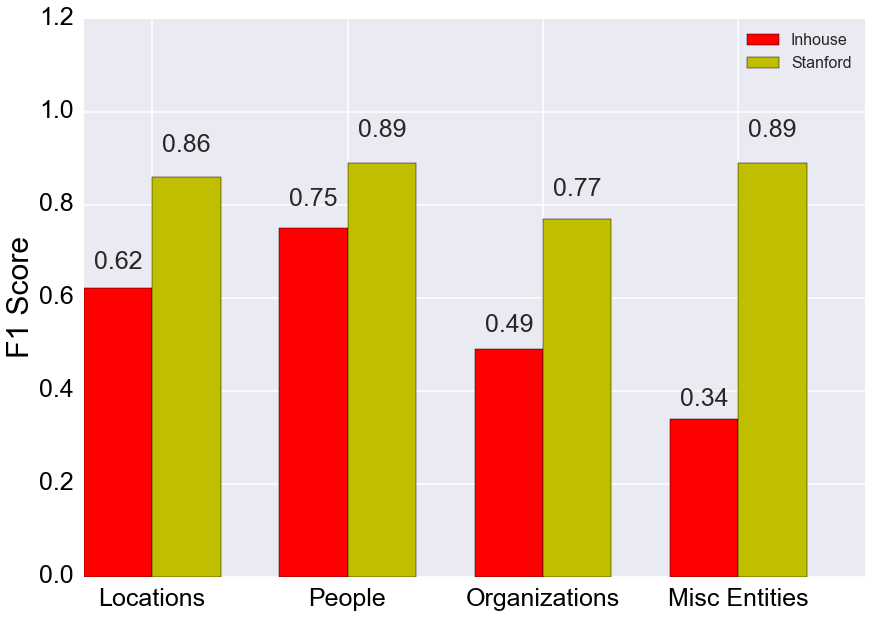

In [3]:
from plots import compare_f1s_conll
compare_f1s_conll()


Perhaps not unexpectedly, the Stanford classifier is performing at higher accuracy levels than the in house classifier on this dataset. However, the CONLL2003 dataset is also relatively widely used, and its possible this data was used for training the Stanford classifier <a href = http://nlp.stanford.edu/software/crf-faq.shtml#data> (the CoreNLP group does not indicate what data was used in training) </a>. As such, we decided to test the two CRF classifiers on a second dataset of <a href = http://schwa.org/projects/resources/wiki/Wikiner#WikiGold> 16K manually annotated wikipedia sentences </a>.

### Performance Test 2


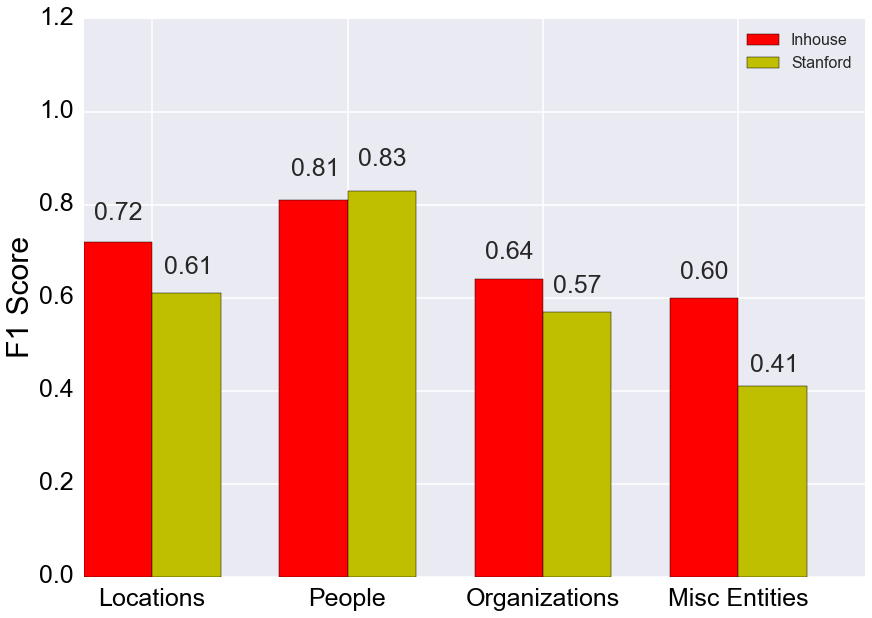

In [4]:
from plots import compare_f1s_wikigold
compare_f1s_wikigold()

Somewhat strikingly, our inhouse classifier improved upon Stanford's classifier for this dataset, particularly for miscellaneous entities. That the in-house CRF is performing better than the Stanford classifier here may be due to the increased similarity of the training and testing data for the in-house classifier versus that for Stanford (both training and testing data were based on wikipedia content for the in-house classifier). That our classifier sees a particular boost in performance as compared to the Stanford classifier for miscellaneous entities may be observed because the in-house CRF was trained with wikipedia data, which could have included a broader range of miscellaneous entities than the training data for the Stanford tagger. Overall, this analysis highlights a well-known problem in NER research, which is that the performance of NER systems can be strongly dependent on the data it is tested on. Just because an NER system performs well on one manually annotated training set, it may not perform as well on all such datasets, which introduces challenges as far as deriving a meaningful evaluation metric. 

### Speed Comparison
In the following comparison we examine the speed of the Stanford classifier, and compare it with our inhouse CRF classifier. We looked at the time to perform NER on a random set of 50, 200, 500 or 1000 web documents extracted from our search index. Each document had been previously stripped of its boiler plate html, using the <a href = https://github.com/seomoz/dragnet>dragnet python library</a>, leaving only raw English text, which was then tokenized into sentences for NER. Each time interval was run 25 times, yielding error bars which reflect the standard errors below. 

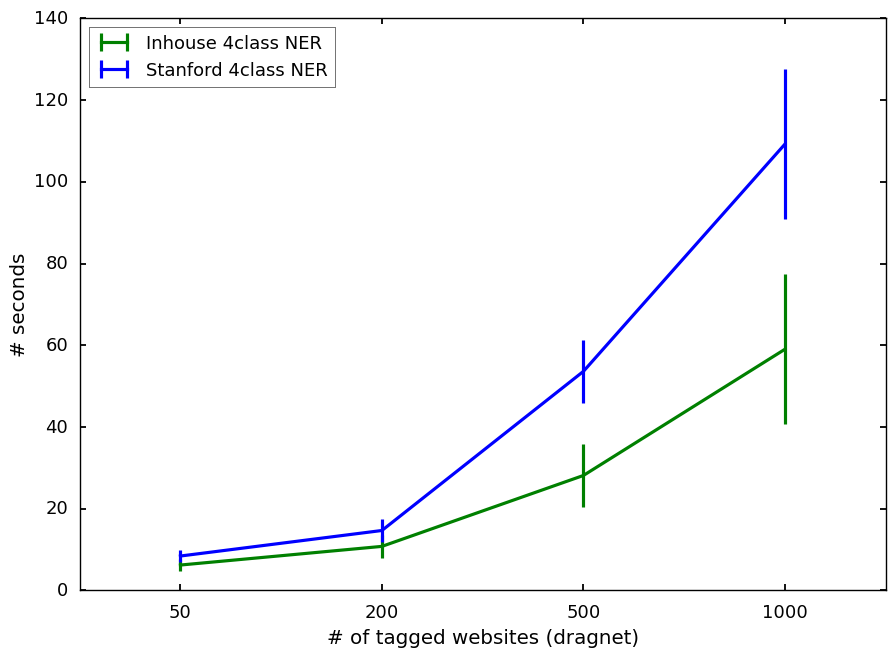

In [5]:
from speedtest import compare_speed 
compare_speed()

The inhouse CRF tagger is performing approximately twice as fast as the Stanford CRF tagger. While the Stanford classifier was not designed for speed, this nevertheless shows that it is not challenging to improve upon this classifier strictly on this level. Indeed, this is an important consideration when considering whether or not to use Stanford's NER tagger in production.

###Conclusion
Overall I was drawn to URX for many reasons including (but not limited to), a) exceptional data scientists, as exemplified by [Science of Crawl series](http://blog.urx.com/urx-blog/2014/9/4/the-science-of-crawl-part-1-deduplication-of-web-content), b) incredible opportunities to develop an exciting search-based product from the ground up, and c) last but not least - extremely kind and generous coworkers. Right now I'm continuing to be involved in moving our current version of NER into production, as well as helping with other science projects including, a) developing AB testing infrastructure, b) search re-ranking using crowd sourced relevancy judgments, and c) a search relevancy dashboard to evaluate our search index.